In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn

13069
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---



# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker

cmap_matrix = 'bwr'

cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for i in range(30):
    plt.close()

path_save_ = "./jupyter-notebooks/NL/results/"

sum psi**2: 1.000e+00


<IPython.core.display.Javascript object>


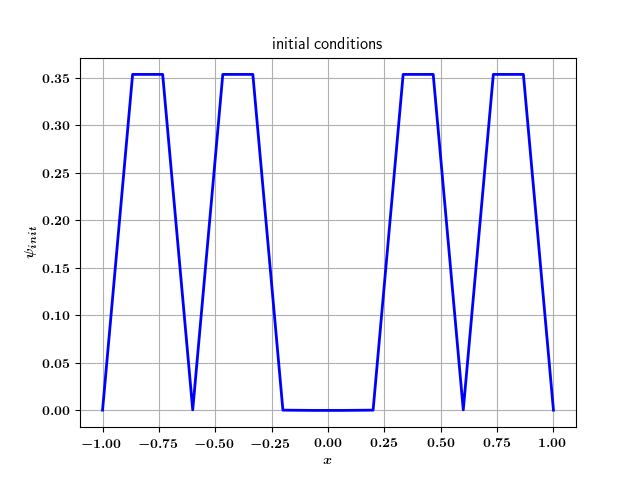

<IPython.core.display.Javascript object>


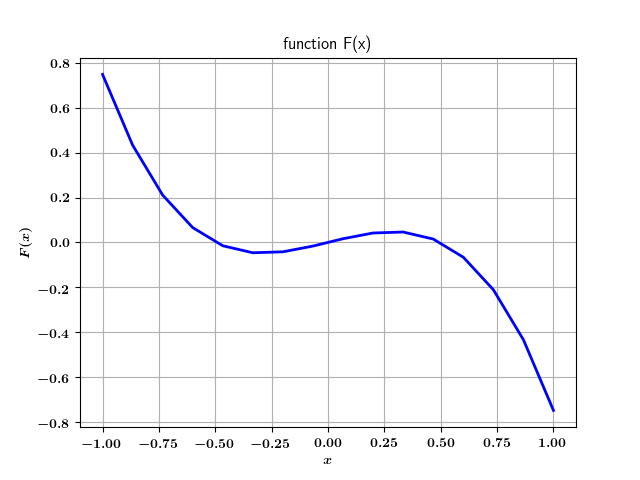

In [7]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------

# --- Choose the case ---
F_ = lambda x:  - x* (x**2 - 0.25)
# F_ = lambda x:  - x**3

nx_, nt_ = 4, 11
t_max, x_max, x_center, flag_second_gauss = 4.0, 1, -0.8, 1.0
delta_gauss = 0.05
# ----------------------------------------

Nx_ = 1<<nx_
Nt_ = 1<<nt_
x_ = np.linspace(-x_max, x_max, Nx_)
t_ = np.linspace(0, t_max, Nt_)
dx_ = np.diff(x_)[0]
dt_ = np.diff(t_)[0]

psi_init_ = np.zeros(Nx_, dtype=float)


coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx_):
    psi_init_[ii] = \
        np.exp(-(x_[ii] - x_center)**2/(2.*delta_gauss**2)) + \
        np.exp(-(x_[ii] + x_center)**2/(2.*delta_gauss**2)) + \
        np.exp(-(x_[ii] + 0.5*x_center)**2/(2.*delta_gauss**2)) + \
        np.exp(-(x_[ii] - 0.5*x_center)**2/(2.*delta_gauss**2))
del ii

norm_psi_init = np.sqrt(np.sum(np.abs(psi_init_)**2))
psi_init_ = psi_init_ / norm_psi_init

print( "sum psi**2: {:0.3e}".format(np.sqrt(np.sum(np.abs(psi_init_)**2))) )

# --- Plot initial state ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_, psi_init_, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$x$')
plt.ylabel("$\psi_{init}$")
plt.title("initial conditions")
plt.grid(True)
plt.show()

# --- Plot the chose F ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_, F_(x_), color='b', linewidth = 2, linestyle='-')
plt.xlabel('$x$')
plt.ylabel("$F(x)$")
plt.title("function F(x)")
plt.grid(True)
plt.show()

In [8]:
# -------------------------------------------------------------
# --- Construct functions  ---
# -------------------------------------------------------------
def construct_UW_matrix():
    A_UW = np.zeros((Nx_, Nx_), dtype=complex)
    for ii in range(1,Nx_-1):
        Fc = F_(x_[ii])

        if Fc <= 0:
            Fp = F_(x_[ii+1])
            A_UW[ii,ii]   = - 2 * Fc
            A_UW[ii,ii+1] = Fp + Fc
        else:
            Fm = F_(x_[ii-1])
            A_UW[ii,ii]   = 2 * Fc
            A_UW[ii,ii-1] = - (Fm + Fc)

        # Fp = F_(x_[ii+1])
        # A_UW[ii,ii]   = - 2 * Fc
        # A_UW[ii,ii+1] = Fp + Fc

    A_UW = -1j/(2.*dx_) * A_UW
    # A_UW[Nx_-2, Nx_-1] = 0.0
    return A_UW


def create_mask(A):
    N = A.shape[0]
    A_mask = np.zeros((N,N))
    for ir in range(N):
        for ic in range(N):
            if np.abs(A[ir,ic]) > 1e-12:
                A_mask[ir, ic] = 1.0
    return A_mask


def plot_matrix_abs(A, name):
    # print("--- Plotting {:s} matrix ---".format(name))
    fontsize = 20
    
    A_mask = create_mask(A)

    fig1 = plt.figure(figsize=(10,10))
    ax = fig1.add_subplot(111)
    cs = ax.matshow(
        A_mask, 
        cmap=cmap_matrix, 
        vmin=-1, vmax = 1
    )
    plt.xlabel('columns', fontsize = fontsize)
    plt.ylabel("rows", fontsize = fontsize)
    plt.title(name)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    return 


def h_adj(AA):
    return np.transpose(np.conjugate(AA))
    

def get_herm_aherm_parts(B):
    Bh = (B + h_adj(B)) / 2.
    Ba = (B - h_adj(B)) / (2.j)
    # B_ch = Bh + 1j * Ba
    return Bh, Ba
# -------------------------------------------------------------
# -------------------------------------------------------------

H = construct_UW_matrix()
Ah, Aa = get_herm_aherm_parts(1j * H)

In [5]:
# ---------------------------------------------------
# --- Plot structure of various matrices ---
# ---------------------------------------------------
for i in range(3):
    plt.close()
plot_matrix_abs(H, "H")
plot_matrix_abs(Ah, "Ah")
plot_matrix_abs(Aa, "Aa")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


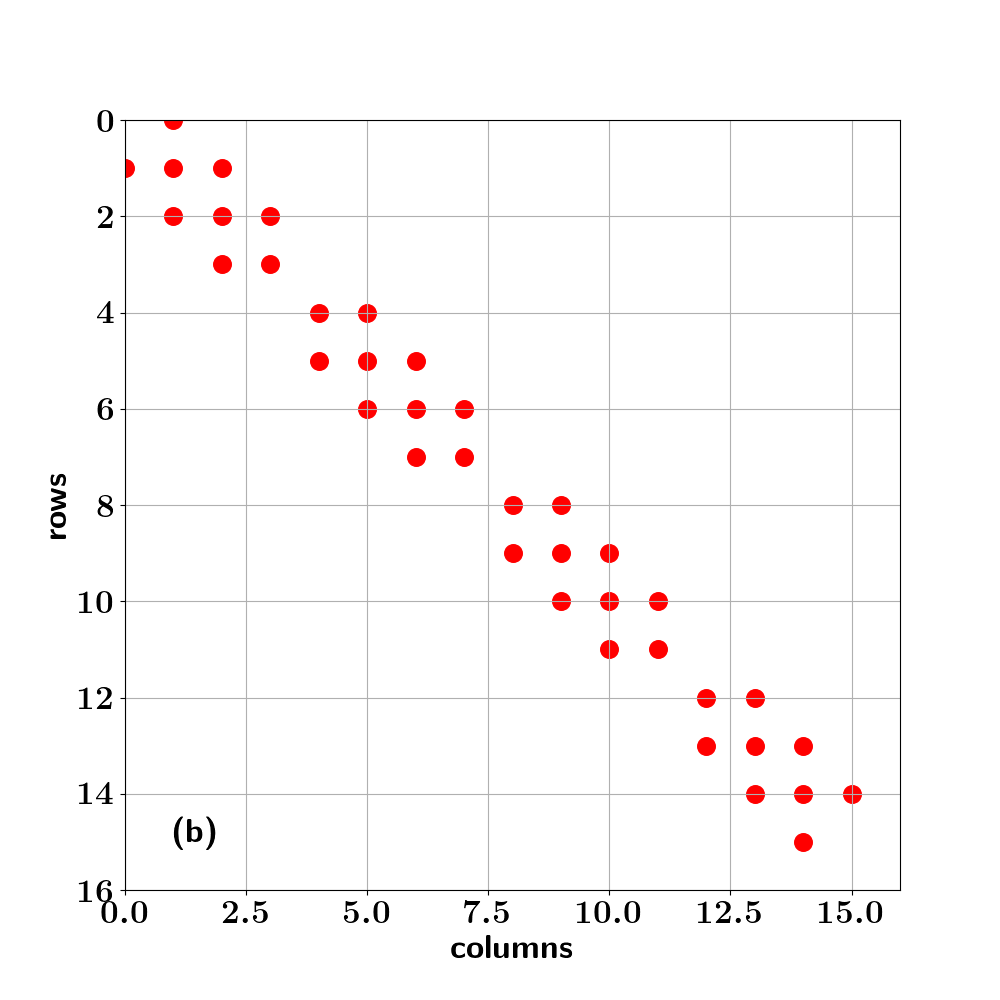

<IPython.core.display.Javascript object>


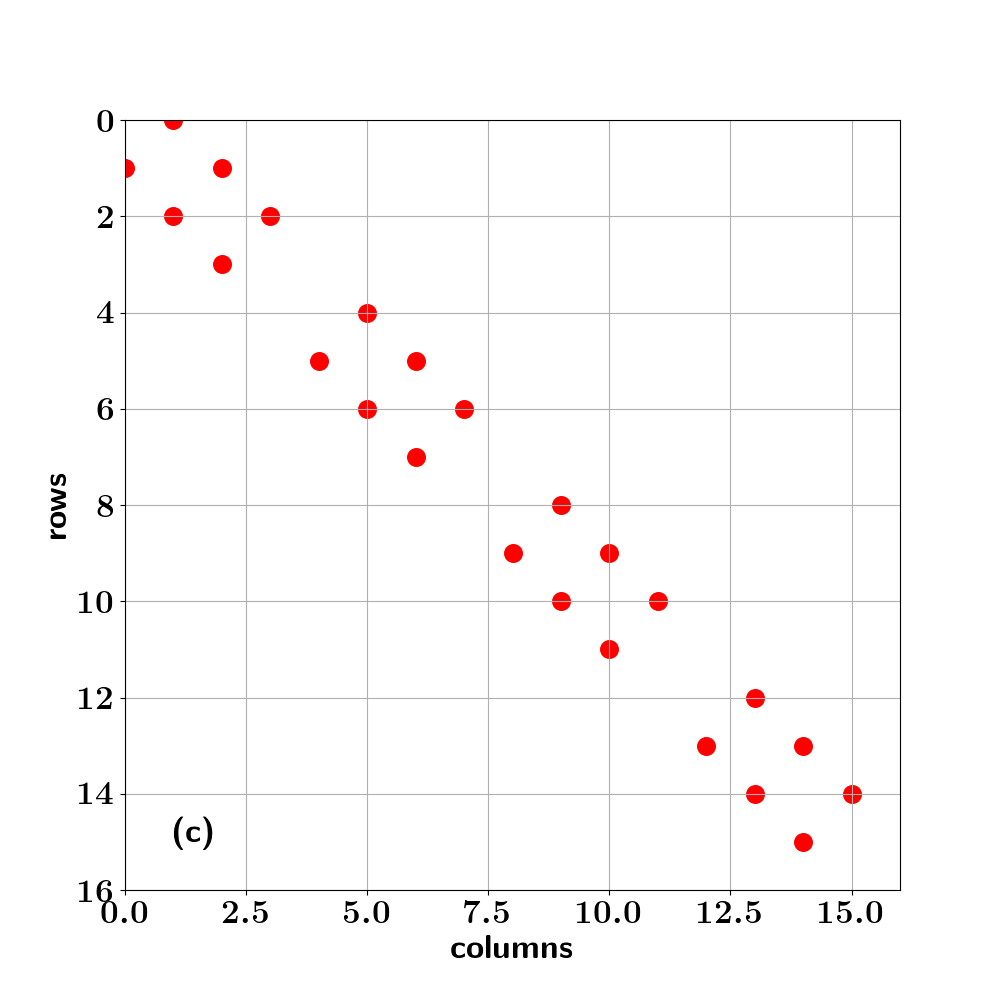

In [12]:
# -----------------------------------------------------------
# --- Funcy plots of matrices (also, save the matrices) ---
# -----------------------------------------------------------
mix.reload_module(kvn)
flag_save = True
path_save = "./jupyter-notebooks/NL/results"
marker_size = 160
text_coord_xy = [1, 15]  # for nx = 4

# matrix_labels = ["", "", ""]
matrix_labels = ["(a)", "(b)", "(c)"]

kvn.plot_A_structure(
    H, matrix_labels[0], "fig_x2_H",
    flag_save = flag_save, 
    path_save = path_save,
    marker_size = marker_size,
    text_coord_xy = text_coord_xy
)
kvn.plot_A_structure(
    Ah, matrix_labels[1], "fig_x2_Ah",
    flag_save = flag_save, 
    path_save = path_save,
    marker_size = marker_size,
    text_coord_xy = text_coord_xy
)
kvn.plot_A_structure(
    Aa, matrix_labels[2], "fig_x2_Aa",
    flag_save = flag_save, 
    path_save = path_save,
    marker_size = marker_size,
    text_coord_xy = text_coord_xy
)

<IPython.core.display.Javascript object>


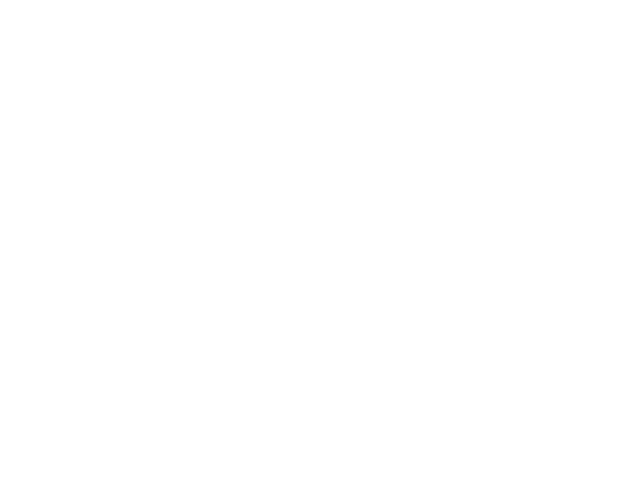

<IPython.core.display.Javascript object>


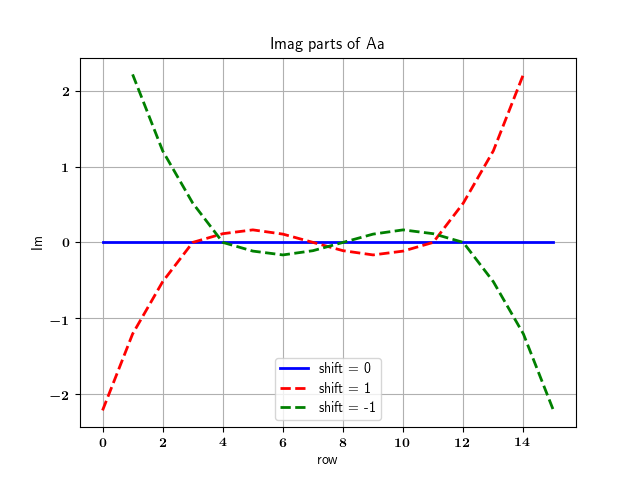

In [11]:
# ---------------------------------------------------------
# --- Print values from matrices ---
# ---------------------------------------------------------
def get_diag(A, i_shift):
    N = A.shape[0]
    diag = np.zeros(N-np.abs(i_shift), dtype=A.dtype)
    if i_shift >= 0:
        chosen_range = range(N-i_shift)
        for ir in range(N-i_shift):
            diag[ir] = A[ir, ir + i_shift]
    else:
        chosen_range = range(-i_shift, N)
        for ir in chosen_range:
            diag[ir + i_shift] = A[ir, ir + i_shift]
    row_range = np.array(chosen_range)
    return diag, row_range


# ---------------------------------------------------------
# A = np.array([
#     [ 0, 1, 2, 3],
#     [-1, 0, 1, 2],
#     [-2,-1, 0, 1],
#     [-3,-2,-1, 0]
# ])
# A = np.array([
#     [    0,  10, 100, 1000],
#     [  -10,   1,  20,  200],
#     [ -100, -10,   2,   30],
#     [-3000,-200, -10,    3]
# ])
# print(get_diag(A, i_shift = -3))




# A_plot, A_name = H, "H"
# A_plot, A_name = Ah, "Ah"
A_plot, A_name = Aa, "Aa"

sh_1 = 0
diag_1, rows_1 = get_diag(A_plot, i_shift = sh_1)

sh_2 = 1
diag_2, rows_2 = get_diag(A_plot, i_shift = sh_2)

sh_3 = -1
diag_3, rows_3 = get_diag(A_plot, i_shift = sh_3)


# --- Real parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.real, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
ax.plot(rows_2, diag_2.real, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
ax.plot(rows_3, diag_3.real, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
plt.xlabel('row')
plt.ylabel("Re")
plt.title("Real parts of {:s}".format(A_name))
plt.legend()
plt.grid(True)
plt.show()

# --- Imaginery parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.imag, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
ax.plot(rows_2, diag_2.imag, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
ax.plot(rows_3, diag_3.imag, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
plt.xlabel('row')
plt.ylabel("Im")
plt.title("Imag parts of {:s}".format(A_name))
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print(np.abs(H))

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [4.441 3.257 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    2.42  1.583 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    1.039 0.495 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.113 0.23  0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.347 0.331 0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.315 0.219 0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.123 0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.123 0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.219 0.315 0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    

In [ ]:
# -------------------------------------------------------------
# --- Block-encoding of the NL problem: - x* (x**2 - 0.25)  ---
# -------------------------------------------------------------